In [ ]:
# Load and sanity-check Kaggle RNN sentiment dataset (reviews.txt + labels.txt)
from pathlib import Path
import pandas as pd

DATA_DIR = Path("../data")          
REV_PATH = DATA_DIR / "reviews.txt"
LAB_PATH = DATA_DIR / "labels.txt"

assert REV_PATH.exists(), f"Missing file: {REV_PATH.resolve()}"
assert LAB_PATH.exists(), f"Missing file: {LAB_PATH.resolve()}"

# Read lines (1 review/label per line)
reviews = REV_PATH.read_text(encoding="utf-8", errors="replace").splitlines()
labels  = LAB_PATH.read_text(encoding="utf-8", errors="replace").splitlines()

# Basic cleanup: keep alignment, drop empty review lines if any
pairs = [(r.strip(), l.strip()) for r, l in zip(reviews, labels) if r.strip() != ""]
reviews, labels = zip(*pairs) if pairs else ([], [])

print("Reviews:", len(reviews))
print("Labels :", len(labels))
print("Counts :", pd.Series(labels).value_counts(dropna=False).to_dict())

# Peek
for i in range(min(3, len(reviews))):
    print("\n---", i, "---")
    print("label:", labels[i])
    print("text :", reviews[i][:300], "..." if len(reviews[i]) > 300 else "")

# Length stats (chars)
lens = pd.Series([len(r) for r in reviews])
print("\nLength (chars) -> min/median/mean/max:",
      int(lens.min()), int(lens.median()), float(lens.mean()), int(lens.max()))


Reviews: 25000
Labels : 25000
Counts : {'positive': 12500, 'negative': 12500}

--- 0 ---
label: positive
text : bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life  such as  teachers  . my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers  . the scramble to survive financially  the ins ...

--- 1 ---
label: negative
text : story of a man who has unnatural feelings for a pig . starts out with a opening scene that is a terrific example of absurd comedy . a formal orchestra audience is turned into an insane  violent mob by the crazy chantings of it  s singers . unfortunately it stays absurd the whole time with no general ...

--- 2 ---
label: positive
text : homelessness  or houselessness as george carlin stated  has been an issue for years but never a plan to help those on the street that were once considered human who did everything from going to school  work  or

labellise

In [2]:
# Labelize (positive -> 1, negative -> 0)
import numpy as np

y_raw = np.char.lower(np.char.strip(np.array(labels)))

label_map = {"positive": 1, "negative": 0}
bad = set(y_raw) - set(label_map.keys())
assert not bad, f"Unexpected labels found: {bad}"

y = np.array([label_map[l] for l in y_raw], dtype=np.int64)
print("Label counts:", {0:int((y==0).sum()), 1:int((y==1).sum())})


Label counts: {0: 12500, 1: 12500}


split train test val

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

X = np.array(reviews)
y_raw = np.char.lower(np.char.strip(np.array(labels)))

label_map = {"positive": 1, "negative": 0}
bad = set(y_raw) - set(label_map.keys())
assert not bad, f"Unexpected labels found: {bad}"

y = np.array([label_map[l] for l in y_raw], dtype=np.int64)

X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, random_state=42, stratify=y_tmp
)

print("Train/Val/Test:", len(X_train), len(X_val), len(X_test))
print("Train label counts:", pd.Series(y_train).value_counts().to_dict())


Train/Val/Test: 20000 2500 2500
Train label counts: {1: 10000, 0: 10000}


tokenise , each word is a token

In [6]:
# Cell 3 — Tokenization + vocab (fast, simple, solid baseline)
import re
from collections import Counter

TOKEN_RE = re.compile(r"[a-z0-9']+")  # simple word tokenizer

def tokenize(text: str):
    return TOKEN_RE.findall(text.lower())

# build vocab from TRAIN only
MAX_VOCAB = 30000
MIN_FREQ = 2

counter = Counter()
for t in X_train:
    counter.update(tokenize(t))

# special tokens
PAD, UNK = "<pad>", "<unk>"
vocab = {PAD: 0, UNK: 1}

for w, c in counter.most_common():
    if c < MIN_FREQ:
        break
    if len(vocab) >= MAX_VOCAB:
        break
    vocab[w] = len(vocab)

print("Vocab size:", len(vocab))

def numericalize(text: str):
    return [vocab.get(tok, vocab[UNK]) for tok in tokenize(text)]

# choose a max length (cap long reviews)
MAX_LEN = 250

def pad_trunc(ids):
    if len(ids) >= MAX_LEN:
        return ids[:MAX_LEN]
    return ids + [vocab[PAD]] * (MAX_LEN - len(ids))


Vocab size: 30000


torch loaders

In [7]:
# Cell 4 — Torch Dataset/DataLoader
import torch
from torch.utils.data import Dataset, DataLoader

class ReviewDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        ids = pad_trunc(numericalize(self.texts[idx]))
        return torch.tensor(ids, dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.float32)

train_ds = ReviewDataset(X_train, y_train)
val_ds   = ReviewDataset(X_val, y_val)
test_ds  = ReviewDataset(X_test, y_test)

BATCH_SIZE = 128
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_dl  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

Embedding: nn.Embedding lookup table, learned from scratch, not contextual.

BiGRU: GRU RNN forward + backward, concatenate outputs.

Mean pooling: average token outputs (ignore <pad>) to get one review vector.


In [8]:
# Cell 5 — A good starter RNN model (Embedding + BiGRU + pooling)
import torch.nn as nn
import torch.nn.functional as F

class SentimentBiGRU(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, hid_dim=128, n_layers=1, dropout=0.3, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.gru = nn.GRU(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if n_layers > 1 else 0.0
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hid_dim * 2, 1)

    def forward(self, x):
        # x: (B, T)
        emb = self.dropout(self.embedding(x))          # (B, T, E)
        out, _ = self.gru(emb)                         # (B, T, 2H)

        # masked mean pooling (ignore PAD)
        mask = (x != vocab[PAD]).unsqueeze(-1)         # (B, T, 1)
        out = out * mask
        summed = out.sum(dim=1)
        denom = mask.sum(dim=1).clamp(min=1)
        pooled = summed / denom                        # (B, 2H)

        logits = self.fc(self.dropout(pooled)).squeeze(1)  # (B,)
        return logits

model = SentimentBiGRU(vocab_size=len(vocab), pad_idx=vocab[PAD]).to(device)
model


SentimentBiGRU(
  (embedding): Embedding(30000, 128, padding_idx=0)
  (gru): GRU(128, 128, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

training
result:
Epoch 04 | train loss 0.1896 acc 0.9250 f1 0.9250 | val loss 0.3294 acc 0.8876 f1 0.8881 | 9.2s

In [9]:
# Cell 6 — Trainer + metrics + early stopping
from sklearn.metrics import accuracy_score, f1_score
from time import time

def run_epoch(model, dl, optimizer=None):
    train_mode = optimizer is not None
    model.train(train_mode)

    losses = []
    all_preds, all_y = [], []

    for xb, yb in dl:
        xb, yb = xb.to(device), yb.to(device)

        logits = model(xb)
        loss = F.binary_cross_entropy_with_logits(logits, yb)

        if train_mode:
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        losses.append(loss.item())
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        preds = (probs >= 0.5).astype(int)
        all_preds.extend(preds.tolist())
        all_y.extend(yb.detach().cpu().numpy().astype(int).tolist())

    return float(np.mean(losses)), accuracy_score(all_y, all_preds), f1_score(all_y, all_preds)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-2)

PATIENCE = 3
best_val = -1.0
best_state = None
pat = 0

history = {"train_loss":[], "train_acc":[], "train_f1":[],
           "val_loss":[], "val_acc":[], "val_f1":[]}

EPOCHS = 20

for epoch in range(1, EPOCHS+1):
    t0 = time()
    tr_loss, tr_acc, tr_f1 = run_epoch(model, train_dl, optimizer=optimizer)
    va_loss, va_acc, va_f1 = run_epoch(model, val_dl, optimizer=None)

    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc); history["train_f1"].append(tr_f1)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc);   history["val_f1"].append(va_f1)

    score = va_f1  # early-stop on F1 (often better than acc)
    improved = score > best_val + 1e-4
    if improved:
        best_val = score
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        pat = 0
    else:
        pat += 1

    print(f"Epoch {epoch:02d} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.4f} f1 {tr_f1:.4f} | "
          f"val loss {va_loss:.4f} acc {va_acc:.4f} f1 {va_f1:.4f} | "
          f"{time()-t0:.1f}s")

    if pat >= PATIENCE:
        print(f"Early stopping (best val F1 = {best_val:.4f})")
        break

# load best
if best_state is not None:
    model.load_state_dict(best_state)


Epoch 01 | train loss 0.5152 acc 0.7368 f1 0.7364 | val loss 0.4506 acc 0.7936 f1 0.8212 | 12.2s
Epoch 02 | train loss 0.3237 acc 0.8626 f1 0.8631 | val loss 0.3292 acc 0.8700 f1 0.8760 | 9.8s
Epoch 03 | train loss 0.2493 acc 0.8989 f1 0.8991 | val loss 0.3435 acc 0.8700 f1 0.8775 | 9.9s
Epoch 04 | train loss 0.1896 acc 0.9250 f1 0.9250 | val loss 0.3294 acc 0.8876 f1 0.8881 | 9.2s
Epoch 05 | train loss 0.1590 acc 0.9385 f1 0.9386 | val loss 0.3456 acc 0.8888 f1 0.8874 | 9.8s
Epoch 06 | train loss 0.1112 acc 0.9587 f1 0.9587 | val loss 0.3748 acc 0.8816 f1 0.8832 | 10.0s
Epoch 07 | train loss 0.0908 acc 0.9680 f1 0.9680 | val loss 0.4323 acc 0.8820 f1 0.8836 | 9.2s
Early stopping (best val F1 = 0.8881)


TEST  loss 0.3471  acc 0.8676  f1 0.8664


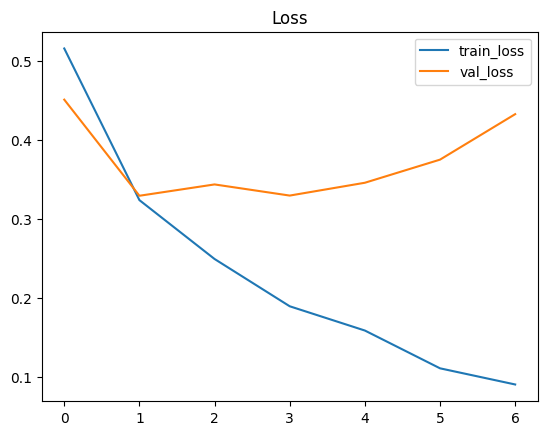

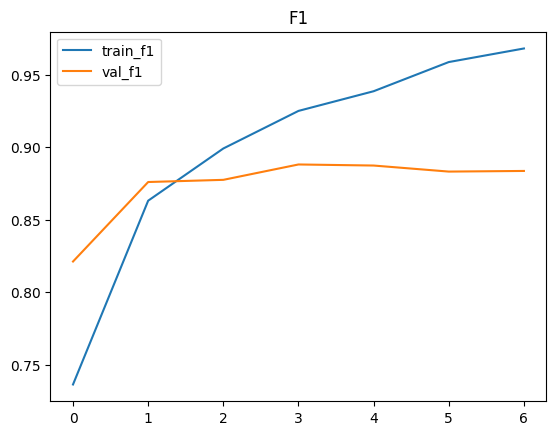

In [11]:
# Cell 7 — Test evaluation + plots
import matplotlib.pyplot as plt

te_loss, te_acc, te_f1 = run_epoch(model, test_dl, optimizer=None)
print(f"TEST  loss {te_loss:.4f}  acc {te_acc:.4f}  f1 {te_f1:.4f}")

plt.figure()
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.figure()
plt.plot(history["train_f1"], label="train_f1")
plt.plot(history["val_f1"], label="val_f1")
plt.legend()
plt.title("F1")
plt.show()


In [12]:
te_loss, te_acc, te_f1 = run_epoch(model, test_dl, optimizer=None)
print(f"TEST  loss {te_loss:.4f}  acc {te_acc:.4f}  f1 {te_f1:.4f}")


TEST  loss 0.3471  acc 0.8676  f1 0.8664


TRYING TO IMPROVE THE RNN

label and split

In [13]:
# Cell 1 — Stratified split (no sklearn)
import numpy as np

X = np.array(reviews)
y_raw = np.char.lower(np.char.strip(np.array(labels)))
label_map = {"positive": 1, "negative": 0}
bad = set(y_raw) - set(label_map.keys())
assert not bad, f"Unexpected labels: {bad}"
y = np.array([label_map[l] for l in y_raw], dtype=np.int64)

def stratified_split(X, y, train_frac=0.8, val_frac=0.1, test_frac=0.1, seed=42):
    assert abs(train_frac + val_frac + test_frac - 1.0) < 1e-9
    rng = np.random.default_rng(seed)

    idx0 = np.where(y == 0)[0]
    idx1 = np.where(y == 1)[0]
    rng.shuffle(idx0); rng.shuffle(idx1)

    def split_idx(idxs):
        n = len(idxs)
        n_train = int(n * train_frac)
        n_val   = int(n * val_frac)
        tr = idxs[:n_train]
        va = idxs[n_train:n_train+n_val]
        te = idxs[n_train+n_val:]
        return tr, va, te

    tr0, va0, te0 = split_idx(idx0)
    tr1, va1, te1 = split_idx(idx1)

    tr = np.concatenate([tr0, tr1])
    va = np.concatenate([va0, va1])
    te = np.concatenate([te0, te1])

    rng.shuffle(tr); rng.shuffle(va); rng.shuffle(te)

    return (X[tr], y[tr], X[va], y[va], X[te], y[te])

X_train, y_train, X_val, y_val, X_test, y_test = stratified_split(X, y, 0.8, 0.1, 0.1, seed=42)
print("Train/Val/Test:", len(X_train), len(X_val), len(X_test))
print("Train label counts:", {0:int((y_train==0).sum()), 1:int((y_train==1).sum())})


Train/Val/Test: 20000 2500 2500
Train label counts: {0: 10000, 1: 10000}


Bigger vocab: MAX_VOCAB 30000 → 50000


Longer sequence: MAX_LEN 250 → 400


In [15]:
# Cell 2 — Tokenizer + vocab (train only) + pad/trunc
import re
from collections import Counter

TOKEN_RE = re.compile(r"[a-z0-9']+")

def tokenize(text: str):
    return TOKEN_RE.findall(text.lower())

MAX_VOCAB = 50000
MIN_FREQ = 2
MAX_LEN  = 400

counter = Counter()
for t in X_train:
    counter.update(tokenize(t))

PAD, UNK = "<pad>", "<unk>"
vocab = {PAD: 0, UNK: 1}

for w, c in counter.most_common():
    if c < MIN_FREQ or len(vocab) >= MAX_VOCAB:
        break
    vocab[w] = len(vocab)

print("Vocab size:", len(vocab))

def numericalize(text: str):
    return [vocab.get(tok, vocab[UNK]) for tok in tokenize(text)]

def pad_trunc(ids):
    if len(ids) >= MAX_LEN:
        return ids[:MAX_LEN]
    return ids + [vocab[PAD]] * (MAX_LEN - len(ids))


Vocab size: 42442


BATCH_SIZE = 64

In [16]:
# Cell 3 — Torch Dataset/DataLoaders
import torch
from torch.utils.data import Dataset, DataLoader

class ReviewDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        ids = pad_trunc(numericalize(self.texts[idx]))
        return torch.tensor(ids, dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.float32)

BATCH_SIZE = 64

train_ds = ReviewDataset(X_train, y_train)
val_ds   = ReviewDataset(X_val, y_val)
test_ds  = ReviewDataset(X_test, y_test)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

adding : 
EmbeddingDropout
Bigger embedding size (128 → 200)
Bigger GRU hidden size(memory state) (128 → 256)
More dropout
Max pooling
Mean + Max together
Bigger linear input because mean+max

In [17]:
# Cell 4 — Improved model: EmbeddingDropout + BiGRU + (mean+max) pooling
import torch.nn as nn
import torch.nn.functional as F

class EmbeddingDropout(nn.Module):
    # Drops embedding dimensions (like SpatialDropout1D)
    def __init__(self, p: float):
        super().__init__()
        self.p = p

    def forward(self, x):
        if not self.training or self.p == 0.0:
            return x
        # x: (B,T,E) -> dropout same mask over T
        mask = x.new_empty((x.size(0), 1, x.size(2))).bernoulli_(1 - self.p)
        x = x * mask / (1 - self.p)
        return x

class SentimentBiGRU_MeanMax(nn.Module):
    def __init__(self, vocab_size, emb_dim=200, hid_dim=256, n_layers=1,
                 dropout=0.45, emb_dropout=0.15, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.emb_drop = EmbeddingDropout(emb_dropout)

        self.gru = nn.GRU(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if n_layers > 1 else 0.0
        )

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hid_dim * 4, 1)  # mean(2H) + max(2H) => 4H

    def forward(self, x):
        # x: (B,T)
        emb = self.embedding(x)         # (B,T,E)
        emb = self.emb_drop(emb)
        emb = self.dropout(emb)

        out, _ = self.gru(emb)          # (B,T,2H)

        mask = (x != vocab[PAD]).unsqueeze(-1)          # (B,T,1) bool
        out_mean = (out * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1)

        out_masked = out.masked_fill(~mask, -1e9)
        out_max = out_masked.max(dim=1).values

        pooled = torch.cat([out_mean, out_max], dim=1)  # (B,4H)
        logits = self.fc(self.dropout(pooled)).squeeze(1)
        return logits

model = SentimentBiGRU_MeanMax(vocab_size=len(vocab), pad_idx=vocab[PAD]).to(device)
model


SentimentBiGRU_MeanMax(
  (embedding): Embedding(42442, 200, padding_idx=0)
  (emb_drop): EmbeddingDropout()
  (gru): GRU(200, 256, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.45, inplace=False)
  (fc): Linear(in_features=1024, out_features=1, bias=True)
)

train
Epoch 04 | lr 1.00e-03 | train loss 0.2615 acc 0.8914 f1 0.8916 | val loss 0.3125 acc 0.8856 f1 0.8871 | 46.5s

In [19]:
# Cell 5 — Trainer with scheduler + early stopping on val loss
import numpy as np
from time import time

def run_epoch(model, dl, optimizer=None):
    train_mode = optimizer is not None
    model.train(train_mode)

    losses = []
    all_probs, all_y = [], []

    for xb, yb in dl:
        xb, yb = xb.to(device), yb.to(device)

        logits = model(xb)
        loss = F.binary_cross_entropy_with_logits(logits, yb)

        if train_mode:
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        losses.append(loss.item())
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        all_probs.extend(probs.tolist())
        all_y.extend(yb.detach().cpu().numpy().astype(int).tolist())

    probs = np.array(all_probs)
    preds = (probs >= 0.5).astype(int)
    ytrue = np.array(all_y)

    acc = float((preds == ytrue).mean())
    tp = int(((preds == 1) & (ytrue == 1)).sum())
    fp = int(((preds == 1) & (ytrue == 0)).sum())
    fn = int(((preds == 0) & (ytrue == 1)).sum())
    prec = tp / (tp + fp + 1e-12)
    rec  = tp / (tp + fn + 1e-12)
    f1   = float(2 * prec * rec / (prec + rec + 1e-12))

    return float(np.mean(losses)), acc, f1

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=1
)

EPOCHS = 25
PATIENCE = 4

best_val_loss = float("inf")
best_state = None
pat = 0

history = {"train_loss":[], "train_acc":[], "train_f1":[],
           "val_loss":[], "val_acc":[], "val_f1":[]}

for epoch in range(1, EPOCHS+1):
    t0 = time()
    tr_loss, tr_acc, tr_f1 = run_epoch(model, train_dl, optimizer=optimizer)
    va_loss, va_acc, va_f1 = run_epoch(model, val_dl, optimizer=None)

    scheduler.step(va_loss)

    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc); history["train_f1"].append(tr_f1)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc);   history["val_f1"].append(va_f1)

    if epoch == 1:
        best_val_f1 = -1.0
    improved = va_f1 > best_val_f1 + 1e-4
    if improved:
        best_val_f1 = va_f1
    if improved:
        best_val_loss = va_loss
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        pat = 0
    else:
        pat += 1

    lr = optimizer.param_groups[0]["lr"]
    print(f"Epoch {epoch:02d} | lr {lr:.2e} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.4f} f1 {tr_f1:.4f} | "
          f"val loss {va_loss:.4f} acc {va_acc:.4f} f1 {va_f1:.4f} | "
          f"{time()-t0:.1f}s")

    if pat >= PATIENCE:
        print(f"Early stopping (best val loss = {best_val_loss:.4f})")
        break

if best_state is not None:
    model.load_state_dict(best_state)


Epoch 01 | lr 1.00e-03 | train loss 0.5629 acc 0.6962 f1 0.6951 | val loss 0.4039 acc 0.8324 f1 0.8283 | 45.0s
Epoch 02 | lr 1.00e-03 | train loss 0.3863 acc 0.8289 f1 0.8297 | val loss 0.3538 acc 0.8556 f1 0.8636 | 41.4s
Epoch 03 | lr 1.00e-03 | train loss 0.3090 acc 0.8689 f1 0.8689 | val loss 0.3938 acc 0.8564 f1 0.8679 | 41.2s
Epoch 04 | lr 1.00e-03 | train loss 0.2615 acc 0.8914 f1 0.8916 | val loss 0.3125 acc 0.8856 f1 0.8871 | 46.5s
Epoch 05 | lr 1.00e-03 | train loss 0.2310 acc 0.9085 f1 0.9087 | val loss 0.3430 acc 0.8820 f1 0.8768 | 41.4s
Epoch 06 | lr 5.00e-04 | train loss 0.2075 acc 0.9174 f1 0.9176 | val loss 0.3222 acc 0.8936 f1 0.8935 | 43.3s
Epoch 07 | lr 5.00e-04 | train loss 0.1684 acc 0.9343 f1 0.9343 | val loss 0.3839 acc 0.8800 f1 0.8859 | 41.4s
Epoch 08 | lr 2.50e-04 | train loss 0.1598 acc 0.9394 f1 0.9395 | val loss 0.3501 acc 0.8920 f1 0.8944 | 42.3s
Early stopping (best val loss = 0.3125)


train but now 
early stopping on val F1
Epoch 05 | lr 2.50e-04 | train loss 0.1345 acc 0.9496 f1 0.9496 | val loss 0.3701 acc 0.8960 f1 0.8982 | 41.7s

In [22]:
# Cell 5 — Trainer with scheduler + early stopping on val F1
import numpy as np
from time import time

def run_epoch(model, dl, optimizer=None):
    train_mode = optimizer is not None
    model.train(train_mode)

    losses = []
    all_probs, all_y = [], []

    for xb, yb in dl:
        xb, yb = xb.to(device), yb.to(device)

        logits = model(xb)
        loss = F.binary_cross_entropy_with_logits(logits, yb)

        if train_mode:
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        losses.append(loss.item())
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        all_probs.extend(probs.tolist())
        all_y.extend(yb.detach().cpu().numpy().astype(int).tolist())

    probs = np.array(all_probs)
    preds = (probs >= 0.5).astype(int)
    ytrue = np.array(all_y)

    acc = float((preds == ytrue).mean())
    tp = int(((preds == 1) & (ytrue == 1)).sum())
    fp = int(((preds == 1) & (ytrue == 0)).sum())
    fn = int(((preds == 0) & (ytrue == 1)).sum())
    prec = tp / (tp + fp + 1e-12)
    rec  = tp / (tp + fn + 1e-12)
    f1   = float(2 * prec * rec / (prec + rec + 1e-12))

    return float(np.mean(losses)), acc, f1

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=1
)

EPOCHS = 25
PATIENCE = 4

best_val_f1 = -1.0
best_state = None
pat = 0

history = {"train_loss":[], "train_acc":[], "train_f1":[],
           "val_loss":[], "val_acc":[], "val_f1":[]}

for epoch in range(1, EPOCHS+1):
    t0 = time()
    tr_loss, tr_acc, tr_f1 = run_epoch(model, train_dl, optimizer=optimizer)
    va_loss, va_acc, va_f1 = run_epoch(model, val_dl, optimizer=None)

    scheduler.step(va_loss)

    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc); history["train_f1"].append(tr_f1)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc);   history["val_f1"].append(va_f1)

    improved = va_f1 > best_val_f1 + 1e-4
    if improved:
        best_val_f1 = va_f1
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        pat = 0
    else:
        pat += 1

    lr = optimizer.param_groups[0]["lr"]
    print(f"Epoch {epoch:02d} | lr {lr:.2e} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.4f} f1 {tr_f1:.4f} | "
          f"val loss {va_loss:.4f} acc {va_acc:.4f} f1 {va_f1:.4f} | "
          f"{time()-t0:.1f}s")

    if pat >= PATIENCE:
        print(f"Early stopping (best val F1 = {best_val_f1:.4f})")
        break

if best_state is not None:
    model.load_state_dict(best_state)


Epoch 01 | lr 1.00e-03 | train loss 0.2257 acc 0.9090 f1 0.9090 | val loss 0.3152 acc 0.8884 f1 0.8875 | 43.7s
Epoch 02 | lr 1.00e-03 | train loss 0.2051 acc 0.9171 f1 0.9171 | val loss 0.3700 acc 0.8868 f1 0.8826 | 42.9s
Epoch 03 | lr 5.00e-04 | train loss 0.1787 acc 0.9304 f1 0.9302 | val loss 0.3313 acc 0.8900 f1 0.8936 | 44.8s
Epoch 04 | lr 5.00e-04 | train loss 0.1464 acc 0.9459 f1 0.9459 | val loss 0.3609 acc 0.8952 f1 0.8955 | 42.0s
Epoch 05 | lr 2.50e-04 | train loss 0.1345 acc 0.9496 f1 0.9496 | val loss 0.3701 acc 0.8960 f1 0.8982 | 41.7s
Epoch 06 | lr 2.50e-04 | train loss 0.1202 acc 0.9543 f1 0.9544 | val loss 0.3677 acc 0.8956 f1 0.8956 | 41.4s
Epoch 07 | lr 1.25e-04 | train loss 0.1164 acc 0.9565 f1 0.9565 | val loss 0.3830 acc 0.8952 f1 0.8963 | 43.1s
Epoch 08 | lr 1.25e-04 | train loss 0.1103 acc 0.9591 f1 0.9591 | val loss 0.3964 acc 0.8936 f1 0.8951 | 45.3s
Epoch 09 | lr 6.25e-05 | train loss 0.1034 acc 0.9614 f1 0.9614 | val loss 0.4201 acc 0.8916 f1 0.8938 | 42.8s
E

test result 
TEST acc 0.8976 f1 0.9008

In [23]:
# Cell 6 — Test eval + confusion matrix + a few errors (no sklearn)
import numpy as np
import torch

model.eval()
all_probs, all_y = [], []
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        logits = model(xb)
        probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.extend(probs.tolist())
        all_y.extend(yb.numpy().astype(int).tolist())

probs = np.array(all_probs)
preds = (probs >= 0.5).astype(int)
ytrue = np.array(all_y)

test_acc = float((preds == ytrue).mean())
tp = int(((preds == 1) & (ytrue == 1)).sum())
fp = int(((preds == 1) & (ytrue == 0)).sum())
tn = int(((preds == 0) & (ytrue == 0)).sum())
fn = int(((preds == 0) & (ytrue == 1)).sum())
prec = tp / (tp + fp + 1e-12)
rec  = tp / (tp + fn + 1e-12)
test_f1 = float(2 * prec * rec / (prec + rec + 1e-12))

print(f"TEST acc {test_acc:.4f} f1 {test_f1:.4f}")
print("Confusion matrix [[tn fp],[fn tp]]:")
print(np.array([[tn, fp],[fn, tp]]))

# show a few wrong predictions
wrong = np.where(preds != ytrue)[0]
print("Wrong predictions:", len(wrong), "out of", len(ytrue))

for i in wrong[:5]:
    print("\n---")
    print("true:", "positive" if ytrue[i]==1 else "negative",
          "| pred:", "positive" if preds[i]==1 else "negative",
          "| prob:", float(probs[i]))
    print(X_test[i][:400])


TEST acc 0.8976 f1 0.9008
Confusion matrix [[tn fp],[fn tp]]:
[[1082  168]
 [  88 1162]]
Wrong predictions: 256 out of 2500

---
true: negative | pred: positive | prob: 0.999767005443573
the five or so really good westerns that mann made are unequaled as an ensemble in hollywood . even john ford never made that many with so much quality . the curious thing about them all is how uneven they are . ford  s my darling clementine is worth about two and a half of any of them . or at least two .  br    br   the real hero of them besides mann and stewart is chase . chase being responsible

---
true: negative | pred: positive | prob: 0.9991075396537781
despite being a huge fan of fred astaire and ginger rogers  movies  it wasn  t until about  years ago that i first saw  follow the fleet  . i knew all the songs from an old astaire  rogers record  yes  vinyl  but knew nothing of the plot .  br    br   unfortunately  while the songs are catchy and ginger rogers  character is sweet and funny  you j

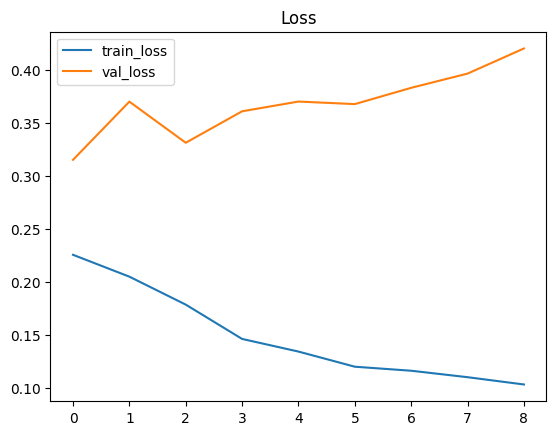

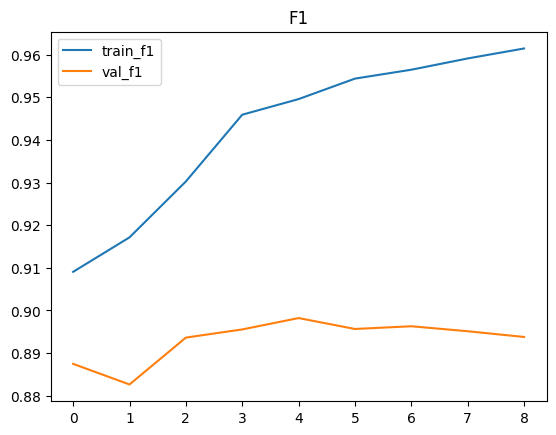

In [24]:
# Cell 7 — Plots (requires matplotlib)
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.figure()
plt.plot(history["train_f1"], label="train_f1")
plt.plot(history["val_f1"], label="val_f1")
plt.legend()
plt.title("F1")
plt.show()


saving

In [25]:
# Save model weights + full model bundle to ../model_weights
from pathlib import Path
import torch
import json

OUT_DIR = Path("../model_weights")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# 1) Save JUST the weights (recommended)
torch.save(model.state_dict(), OUT_DIR / "sentiment_bigru_meanmax_state_dict.pt")

# 2) Save a full training bundle (weights + vocab + important config)
bundle = {
    "state_dict": model.state_dict(),
    "vocab": vocab,
    "pad_token": PAD,
    "unk_token": UNK,
    "max_len": MAX_LEN,
    "model_class": type(model).__name__,
    # adjust these if you changed them
    "model_hparams": {
        "emb_dim": 200,
        "hid_dim": 256,
        "n_layers": 1,
        "dropout": 0.45,
        "emb_dropout": 0.15,
        "pad_idx": vocab[PAD],
        "vocab_size": len(vocab),
    },
}
torch.save(bundle, OUT_DIR / "sentiment_bigru_meanmax_bundle.pt")

print("Saved to:", OUT_DIR.resolve())
print("Files:", [p.name for p in OUT_DIR.iterdir()])


Saved to: C:\Users\fessu\OneDrive\Desktop\personal_work\rnn_from_scratch\model_weights
Files: ['sentiment_bigru_meanmax_bundle.pt', 'sentiment_bigru_meanmax_state_dict.pt']


In [26]:
bundle = torch.load("../model_weights/sentiment_bigru_meanmax_bundle.pt", map_location="cpu")
vocab = bundle["vocab"]
MAX_LEN = bundle["max_len"]

model = SentimentBiGRU_MeanMax(**bundle["model_hparams"])
model.load_state_dict(bundle["state_dict"])
model.eval()


SentimentBiGRU_MeanMax(
  (embedding): Embedding(42442, 200, padding_idx=0)
  (emb_drop): EmbeddingDropout()
  (gru): GRU(200, 256, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.45, inplace=False)
  (fc): Linear(in_features=1024, out_features=1, bias=True)
)

checking results if we used transformers

In [1]:
%pip -q install -U transformers datasets accelerate evaluate

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\fessu\OneDrive\Desktop\personal_work\rnn_from_scratch\rnn_env\scripts\python.exe -m pip install --upgrade pip' command.


In [1]:
from pathlib import Path
import numpy as np

DATA_DIR = Path("../data")
reviews = (DATA_DIR / "reviews.txt").read_text(encoding="utf-8", errors="replace").splitlines()
labels  = (DATA_DIR / "labels.txt").read_text(encoding="utf-8", errors="replace").splitlines()

reviews = [r.strip() for r in reviews]
labels  = [l.strip().lower() for l in labels]

label_map = {"positive": 1, "negative": 0}
y = np.array([label_map[l] for l in labels], dtype=np.int64)
X = np.array(reviews)

def stratified_split_idx(y, train_frac=0.8, val_frac=0.1, test_frac=0.1, seed=42):
    rng = np.random.default_rng(seed)
    idx0 = np.where(y == 0)[0]; idx1 = np.where(y == 1)[0]
    rng.shuffle(idx0); rng.shuffle(idx1)

    def split(idxs):
        n = len(idxs)
        n_tr = int(n * train_frac)
        n_va = int(n * val_frac)
        return idxs[:n_tr], idxs[n_tr:n_tr+n_va], idxs[n_tr+n_va:]

    tr0, va0, te0 = split(idx0)
    tr1, va1, te1 = split(idx1)

    tr = np.concatenate([tr0, tr1])
    va = np.concatenate([va0, va1])
    te = np.concatenate([te0, te1])

    rng.shuffle(tr); rng.shuffle(va); rng.shuffle(te)
    return tr, va, te

tr_idx, va_idx, te_idx = stratified_split_idx(y, 0.8, 0.1, 0.1, seed=42)

train_texts, train_labels = X[tr_idx].tolist(), y[tr_idx].tolist()
val_texts,   val_labels   = X[va_idx].tolist(), y[va_idx].tolist()
test_texts,  test_labels  = X[te_idx].tolist(), y[te_idx].tolist()

print(len(train_texts), len(val_texts), len(test_texts))


20000 2500 2500


In [2]:
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

ds = DatasetDict({
    "train": Dataset.from_dict({"text": train_texts, "label": train_labels}),
    "val":   Dataset.from_dict({"text": val_texts,   "label": val_labels}),
    "test":  Dataset.from_dict({"text": test_texts,  "label": test_labels}),
})

MAX_LEN = 256  # 128 is faster; 256 is safer for longer reviews

def tok(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=MAX_LEN)

ds = ds.map(tok, batched=True)
ds = ds.remove_columns(["text"])
ds.set_format("torch")
ds


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 20000
    })
    val: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2500
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2500
    })
})

In [4]:
import os
import numpy as np
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    DataCollatorWithPadding,
)

os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"
os.environ["HF_HOME"] = os.path.abspath("./hf_cache")

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    acc = (preds == labels).mean()
    tp = ((preds == 1) & (labels == 1)).sum()
    fp = ((preds == 1) & (labels == 0)).sum()
    fn = ((preds == 0) & (labels == 1)).sum()
    prec = tp / (tp + fp + 1e-12)
    rec  = tp / (tp + fn + 1e-12)
    f1   = 2 * prec * rec / (prec + rec + 1e-12)
    return {"accuracy": float(acc), "f1": float(f1)}

# If your ds still has a "text" column, tokenize it first:
# ds = ds.map(lambda b: tokenizer(b["text"], truncation=True), batched=True).remove_columns(["text"])
# ds.set_format("torch")

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

args = TrainingArguments(
    output_dir="../model_weights/distilbert_from_pretrained",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_steps=200,                 # ✅ avoids warmup_ratio warning
    fp16=torch.cuda.is_available(),
    report_to="none",
)

# ✅ IMPORTANT: no tokenizer=... (your Trainer rejects it)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds["train"],
    eval_dataset=ds["val"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)],
)

trainer.train()
print("TEST:", trainer.evaluate(ds["test"]))


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.bias     | MISSING    | 
pre_classifier.weight   | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.315463,0.270417,0.898000,0.902036
2,0.182457,0.269382,0.910000,0.910537
3,0.105800,0.344777,0.914000,0.914103


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


TEST: {'eval_loss': 0.35979074239730835, 'eval_accuracy': 0.9088, 'eval_f1': 0.908507223113464, 'eval_runtime': 4.3037, 'eval_samples_per_second': 580.896, 'eval_steps_per_second': 18.356, 'epoch': 3.0}


In [5]:
trainer.evaluate(ds["test"])


{'eval_loss': 0.35979074239730835,
 'eval_accuracy': 0.9088,
 'eval_f1': 0.908507223113464,
 'eval_runtime': 4.6163,
 'eval_samples_per_second': 541.563,
 'eval_steps_per_second': 17.113,
 'epoch': 3.0}

transformers accuracy : 0.9088
second rnn : 0.8976
first rnn : acc 0.8676